In [1]:
import os

from dotenv import load_dotenv

# Load environment variables
load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")

# Create vector store


In [2]:
# Workaround for the issues using asyncio

import nest_asyncio

nest_asyncio.apply()

In [3]:
from langchain_chroma import Chroma
from langchain_community.document_loaders import GitbookLoader
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


# Read Gitbook
def load_gitbook(url: str = "https://bentobatch.gitbook.io"):
    loader = GitbookLoader(url, load_all_paths=True)
    data = loader.load()
    return data


# Load the documents from Gitbook
docs = load_gitbook()


# Split the documents into chunks.
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
vector_store = Chroma.from_documents(documents=splits, embedding=embedding_model)
retriever = vector_store.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.
/opt/homebrew/Cellar/python@3.11/3.11.8/Frameworks/Python.framework/Versions/3.11/lib/python3.11/html/parser.py:170: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  k = self.parse_starttag(i)
Fetching pages: 100%|##########| 41/41 [00:01<00:00, 27.43it/s]


In [4]:
retriever.invoke("What is Bento Batch?")

[Document(metadata={'source': 'https://bentobatch.gitbook.io/bentobatch/getting-started/faq', 'title': '❓FAQ'}, page_content="❓\nFAQ\nWhat is Bento Batch?\nBento Batch is a Streamlined Transaction Layer, leveraging Account Abstraction technique to upscale blockchain efficiency, providing an easier, cheaper, and safer on-chain experience.\nWhat is Batch?\nBatch is a bundle of on-chain interactions, consolidating them into a single transaction. With just One Click on Batch, all interactions are completed, eliminating the need for multiple signs and confirmations.\nHow do I collect Bento Box?\nExecute a Batch to earn Bento Boxes! With higher gas fees, more transactions per Batch, and larger volume input, you'll receive more Bento Boxes as rewards!\nRefer your friends and receive an additional 10% of their Bento Boxes as a bonus!\nHow do I refer Batch to frens?\nYou can find a referral link on every Batch page! Just head to the Batch page, and you'll see the share link right next to the Ba

### Another Tool


In [5]:
from langchain_core.tools import StructuredTool, ToolException
from langchain.tools.retriever import create_retriever_tool


def get_account_info(account: str):
    """
    Retrieves the user's wallet information, which includes
    the most frequently used cryptocurrencies (tokens), frequently interacted networks (chains), and transaction history.
    """
    if not account.startswith("0x") or len(account) != 42:
        raise ToolException("Error: Invalid account address: ${account}")

    return {
        "account": account,
        "assets": ["USDT", "USDC", "ETH"],
        "chains": ["Ethereum", "Blast"],
    }


get_account_info_tool = StructuredTool.from_function(
    func=get_account_info,
    handle_tool_error=True,
)

print(get_account_info_tool.args)

get_account_info_tool.invoke({"account": "0x436f795B64E23E6cE7792af4923A68AFD3967952"})

{'account': {'title': 'Account', 'type': 'string'}}


{'account': '0x436f795B64E23E6cE7792af4923A68AFD3967952',
 'assets': ['USDT', 'USDC', 'ETH'],
 'chains': ['Ethereum', 'Blast']}

In [6]:
bento_gitbook_retriever = create_retriever_tool(
    retriever,
    "bentobatch_gitbook_retriever",
    "Answers question about Bento Batch",
)

tools = [bento_gitbook_retriever, get_account_info_tool]

# Agent


In [7]:
from langchain_core.messages import HumanMessage
from langchain_core.prompts import ChatPromptTemplate
from langgraph.checkpoint.sqlite import SqliteSaver
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent


memory = SqliteSaver.from_conn_string(":memory:")

model = ChatOpenAI(model="gpt-4o-mini")

# todo: this is a dummy account address
account = "0x436f795B64E23E6cE7792af4923A68AFD3967952"

agent_executor = create_react_agent(model, tools=tools, checkpointer=memory)

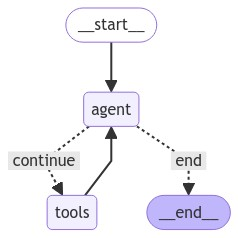

In [8]:
from IPython.display import Image, display

try:
    display(Image(agent_executor.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)
    pass

In [9]:
config = {"configurable": {"thread_id": "123"}}

response = agent_executor.invoke(
    {"messages": [HumanMessage(content="Hi")]}, config=config
)
response

{'messages': [HumanMessage(content='Hi', id='76d5970d-8cc3-4e84-8971-fd60c51df793'),
  AIMessage(content='Hello! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 102, 'total_tokens': 112}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_7dd529cfca', 'finish_reason': 'stop', 'logprobs': None}, id='run-425277f8-65ec-413f-9c82-dfc5e84272cd-0', usage_metadata={'input_tokens': 102, 'output_tokens': 10, 'total_tokens': 112})]}

In [10]:
query = "Tell me about my account info"
response = agent_executor.invoke(
    {"messages": [HumanMessage(content=query)]}, config=config
)
print(response["messages"][-1].content)

Please provide me with your account address so that I can retrieve your account information.


In [11]:
query = "My account address is 0x436f795B64E23E6cE7792af4923A68AFD3967952"
response = agent_executor.invoke(
    {"messages": [HumanMessage(content=query)]}, config=config
)
print(response["messages"][-1].content)

Here is the information about your account:

- **Account Address:** 0x436f795B64E23E6cE7792af4923A68AFD3967952
- **Frequently Used Assets:**
  - USDT (Tether)
  - USDC (USD Coin)
  - ETH (Ethereum)
- **Frequently Interacted Networks:**
  - Ethereum
  - Blast

If you need more details or have any other questions, feel free to ask!


In [12]:
query = "Recommend me a batch case"
response = agent_executor.invoke(
    {"messages": [HumanMessage(content=query)]}, config=config
)
print(response["messages"][-1].content)

I recommend exploring the **Scroll Batch** case, which allows you to interact with a decentralized exchange (Dex) on the Scroll network. Here's a breakdown of the different levels available:

1. **Rookie Level**
   - Number of Contracts Interacted: 2
   - On-Chain Volume Boost: 4x
   - Clicks Saved: 4
   - [Learn More](https://bentobatch.com/case/scroll_airdrop_hunting_rookie)

2. **Advanced Level**
   - Number of Contracts Interacted: 7
   - On-Chain Volume Boost: 10x
   - Clicks Saved: 15
   - [Learn More](https://bentobatch.com/case/scroll_airdrop_hunting_advanced)

3. **Professional Level**
   - Number of Contracts Interacted: 9
   - On-Chain Volume Boost: 13x
   - Clicks Saved: 21
   - [Learn More](https://bentobatch.com/case/scroll_airdrop_hunting_professional)

These cases utilize BentoBatch's technology to simplify your on-chain interactions and save on gas fees. If you have any specific preferences or need more information, let me know!


In [13]:
query = "Can you provide some Airdrop cases on Scroll chain?"
response = agent_executor.invoke(
    {"messages": [HumanMessage(content=query)]}, config=config
)
print(response["messages"][-1].content)

Here are some airdrop cases on the Scroll chain that you can explore:

1. **Rookie Level Airdrop**
   - Number of Contracts Interacted: 2
   - On-Chain Volume Boost: 4x
   - Clicks Saved: 4
   - [Participate Here](https://bentobatch.com/case/scroll_airdrop_hunting_rookie)

2. **Advanced Level Airdrop**
   - Number of Contracts Interacted: 7
   - On-Chain Volume Boost: 10x
   - Clicks Saved: 15
   - [Participate Here](https://bentobatch.com/case/scroll_airdrop_hunting_advanced)

3. **Professional Level Airdrop**
   - Number of Contracts Interacted: 9
   - On-Chain Volume Boost: 13x
   - Clicks Saved: 21
   - [Participate Here](https://bentobatch.com/case/scroll_airdrop_hunting_professional)

These airdrop cases allow you to interact with various contracts on the Scroll network and maximize your on-chain volume while saving on clicks. If you have any questions or need further assistance, feel free to ask!
